# Cross Validation

Analysis of the predicted arsenic levels for the county on Gaston Water Map. Compares data to the actual levels of arsenic in the county 2018-2022 and contrasts to 2011-2017 since the model was trained on data 2011-2017. 


In [1]:
import geopandas as gpd
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely as shp  


In [2]:
# read in samples, predicted arsenic and public water systems polygon data

#pred = gpd.read_file("../data/gis/polygon/predicted-arsenic-clipped.geojson")

pred = gpd.read_file("../data/gis/polygon/predicted-arsenic.geojson")

ar = gpd.read_file("../data/gis/point/ar_samples_w_covariates.geojson")


# check length of data
print(len(ar))

# check crs for both dataframes

print(ar.crs)
print(pred.crs)


1683
EPSG:4269
EPSG:2264


<Axes: >

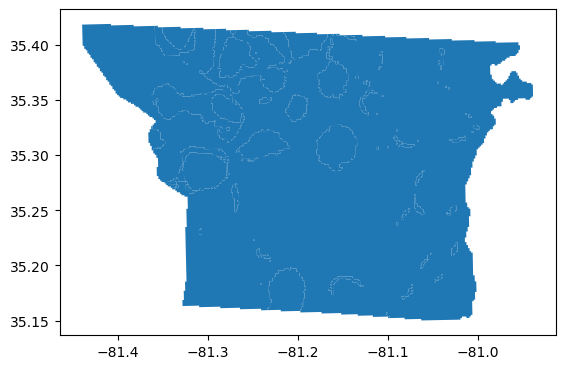

In [16]:
pred.plot()

Assessing accuracy of the model based on actual arsenic level

In [3]:
pred = pred.to_crs(ar.crs)

In [4]:
pred['pred'] = pred['severity'].replace(['good','warn','danger'],['< 0.005','0.005 - 0.01','> 0.01'])
pred = pred[["geometry", "pred"]]

# join the pred column to ar dataframe using spatial join

ar = gpd.sjoin(ar, pred, how="left", predicate="within")

In [5]:
# filter ar by whether category is 'warn'

ar_warn = ar[ar['pred'] == '0.005 - 0.01']

# keep pred, ar, group_five, columns

ar_warn = ar_warn[['pred','ar','group_five']]

# check length of data

print(len(ar_warn))

231


In [6]:
# chack ar value counts 

print(ar_warn['ar'].value_counts())

# check group_five value counts

print(ar_warn['group_five'].value_counts())



ar
0.000    186
0.001      9
0.006      8
0.007      6
0.004      5
0.009      4
0.008      3
0.003      2
0.013      2
0.002      2
0.005      1
0.012      1
0.018      1
0.011      1
Name: count, dtype: int64
group_five
0    204
1     27
Name: count, dtype: int64


In [7]:
# check each point has a prediction

print(ar['pred'].isnull().sum())

2


In [8]:
# drop rows with no prediction

ar = ar.dropna(subset=['pred'])

In [9]:
# create dummy variable for pred column

df= pd.get_dummies(ar, columns=["pred"])

#Did it at least predict the samples above MCL as being at least above 0.005? aka either 1 for the pred_0.005 - 0.01 or 1 for the pred_> 0.01 

#On the same note, were the samples below MCL predicted to be below 0.005? aka either 1 for the pred_0.005 - 0.01 or 1 for the pred_< 0.005

# create pred_group_five, pred_group_mcl columns
# pred_group_five = 1 if pred_0.005 - 0.01 or pred_> 0.01 , else 0
# pred_group_mcl = 1 if pred_> 0.01 , else 0

def pred_group_five(df):
    li = []
    for i in df.index:
        if df['pred_0.005 - 0.01'][i] == 1 or df['pred_> 0.01'][i] == 1:
            li.append(1)
        else:
            li.append(0)
    return li


def pred_group_mcl(df):

    li = []
    for i in df.index:
        if df['pred_> 0.01'][i] == 1:
            li.append(1)
        else:
            li.append(0)
    return li

ar['group_five_pred'] = pred_group_five(df)

ar['group_mcl_pred'] = pred_group_mcl(df)


In [10]:
def concordance(df):
    li = []

    for i in df.index:
        if df['ar'][i] < 0.005 and df['pred_< 0.005'][i] == 1:
            li.append(1)
        elif 0.005 <= df['ar'][i] <= 0.01 and df['pred_0.005 - 0.01'][i] == 1:
            li.append(1)
        elif df['ar'][i] > 0.01 and df['pred_> 0.01'][i] == 1:
            li.append(1)
        else:
            li.append(0)
    return li

In [11]:
ar['correct'] = concordance(df)

In [12]:
ar['correct'].value_counts()

correct
1    1442
0     239
Name: count, dtype: int64

In [13]:
# crosstab the correct column with the pred column

pd.crosstab(ar['correct'], ar['pred'])

pred,0.005 - 0.01,< 0.005,> 0.01
correct,,,
0,209,8,22
1,22,1401,19


In [17]:
# run the concordace again on a subset for years < 2018

ar_2017 = ar[ar['year_tested'] < 2018]
df_2017 = df[df['year_tested'] < 2018]
ar_2017['correct'] = concordance(df_2017)
pd.crosstab(ar_2017['correct'], ar_2017['pred'])

c:\Users\kendall\miniconda3\envs\pygis\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


pred,0.005 - 0.01,< 0.005,> 0.01
correct,,,
0,111,2,13
1,15,865,16


In [18]:
# run the concordace again on a subset for years > 2018

ar_2018 = ar[ar['year_tested'] > 2018]
df_2018 = df[df['year_tested'] > 2018]

ar_2018['correct'] = concordance(df_2018)
pd.crosstab(ar_2018['correct'], ar_2018['pred'])

c:\Users\kendall\miniconda3\envs\pygis\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


pred,0.005 - 0.01,< 0.005,> 0.01
correct,,,
0,88,6,8
1,7,472,3


Assessing accuracy of the model based on binary classification of arsenic levels

In [19]:
# definition to calculate accuracy (tn + tp) / (tp + tn + fp + fn)
# sensitivity = tp / (tp + fn)
# specificity = tn / (tn + fp)
# precision = tp / (tp + fp)
# false positive rate = fp / (fp + tn)
# false negative rate = fn / (fn + tp)

def classifier_metrics(obs, pred):
    A = 0
    B = 0
    C = 0
    D = 0
    for i in range(len(obs)):
        if obs[i] == 1 and pred[i] == 1:
            A += 1
        elif obs[i] == 0 and pred[i] == 1:
            B += 1    
        elif obs[i] == 1 and pred[i] == 0:
            C += 1
        elif obs[i] == 0 and pred[i] == 0:
            D += 1

    sensitivity = round(A / (A + C), 2)
    specificity = round(D / (D + B), 2)

    print(f'Confusion Matrix: \n{A} {B} \n{C} {D}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'Accuracy: {round((A + D) / (A + B + C + D), 2)}')
    print(f'Precision: {round(A / (A + B), 2)}')
    print(f'False Positive Rate: {round(B / (B + D), 2)}')
    print(f'False Negative Rate: {round(C / (C + A), 2)}')

Model metrics using 5ppb as the threshold for elevated prediction (combine 'warn' and 'danger' from map)

In [20]:
# for all samples
print('Model Accuracy for All Samples, Threshold = 5ppb')
classifier_metrics(ar['group_five'], ar['group_five_pred'])

Model Accuracy for All Samples, Threshold = 5ppb
Confusion Matrix: 
50 222 
8 1401
Sensitivity: 0.86
Specificity: 0.86
Accuracy: 0.86
Precision: 0.18
False Positive Rate: 0.14
False Negative Rate: 0.14


In [21]:
# for samples < 2018
ar_2017.reset_index(inplace=True)
print('Model Accuracy for Samples Tested Before 2018, Threshold = 5ppb')
classifier_metrics(ar_2017['group_five'], ar_2017['group_five_pred'])

Model Accuracy for Samples Tested Before 2018, Threshold = 5ppb
Confusion Matrix: 
38 117 
2 865
Sensitivity: 0.95
Specificity: 0.88
Accuracy: 0.88
Precision: 0.25
False Positive Rate: 0.12
False Negative Rate: 0.05


In [22]:
# for samplees > 2018


ar_2018.reset_index(inplace=True)
print('Model Accuracy for Samples Tested After 2018, Threshold = 5ppb')
classifier_metrics(ar_2018['group_five'], ar_2018['group_five_pred'])

Model Accuracy for Samples Tested After 2018, Threshold = 5ppb
Confusion Matrix: 
12 94 
6 472
Sensitivity: 0.67
Specificity: 0.83
Accuracy: 0.83
Precision: 0.11
False Positive Rate: 0.17
False Negative Rate: 0.33


Model metrics using 5ppb as the threshold for elevated prediction ( 'danger' from map = 1)

In [23]:
print('Model Accuracy for All Samples, Threshold = 10ppb')
classifier_metrics(ar['group_mcl'], ar['group_mcl_pred'])

Model Accuracy for All Samples, Threshold = 10ppb
Confusion Matrix: 
20 21 
11 1629
Sensitivity: 0.65
Specificity: 0.99
Accuracy: 0.98
Precision: 0.49
False Positive Rate: 0.01
False Negative Rate: 0.35


In [24]:
print('Model Accuracy for Samples Tested Before 2018, Threshold = 10ppb')
classifier_metrics(ar_2017['group_mcl'], ar_2017['group_mcl_pred'])

Model Accuracy for Samples Tested Before 2018, Threshold = 10ppb
Confusion Matrix: 
17 12 
5 988
Sensitivity: 0.77
Specificity: 0.99
Accuracy: 0.98
Precision: 0.59
False Positive Rate: 0.01
False Negative Rate: 0.23


In [25]:
print('Model Accuracy for Samples Tested After 2018, Threshold = 10ppb')
classifier_metrics(ar_2018['group_mcl'], ar_2018['group_mcl_pred'])

Model Accuracy for Samples Tested After 2018, Threshold = 10ppb
Confusion Matrix: 
3 8 
6 567
Sensitivity: 0.33
Specificity: 0.99
Accuracy: 0.98
Precision: 0.27
False Positive Rate: 0.01
False Negative Rate: 0.67


In [26]:
ar['group_five'].value_counts()

group_five
0    1623
1      58
Name: count, dtype: int64



<details><summary>QUESTION: How can we tell if a model is underfitting?</summary>
We know it is underfitting by observing a large training and test error.
</details>

---
### **Example: How Can We Reduce the High Bias?**
According to the bias-variance tradeoff, to reduce the bias (and make the fit better), we must increase the model variance (and make it more sensitive to noise).

#### Approach: Increase Variance by Adding More Parameters
Adding more parameters increases the "model complexity" -- and hence allows it more flexibility to fit the data (i.e. a lower bias).

## The Tradeoff

One goal of predictive modeling is to find the optimal "sweet spot" in which we minimize our error.  One common strategy that we'll learn tomorrow deals with **cross-validation**, which entails testing the accuracy of our model on unseen data, then evaluating if it's overfit or not (more on this tomorrow).  Ideally, we're trying to find the ideal balance of bias and variance that allows us to generalize well.

### Increasing Model Complexity
- Bias decreases
- Variance increases (the model is more squigly)

![image.png](attachment:image.png)


## So how can we fix it?

<details><summary>If your model has error due to high bias:
</summary>
    
- Get more data
- Get a better sample of data
- Increase complexity of model
    